In [12]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from astropy.cosmology import LambdaCDM
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import corner
import emcee
import time
import dynesty
from scipy.stats import uniform
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import scipy

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_13196\3125471657.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


(35.0, 50.0)

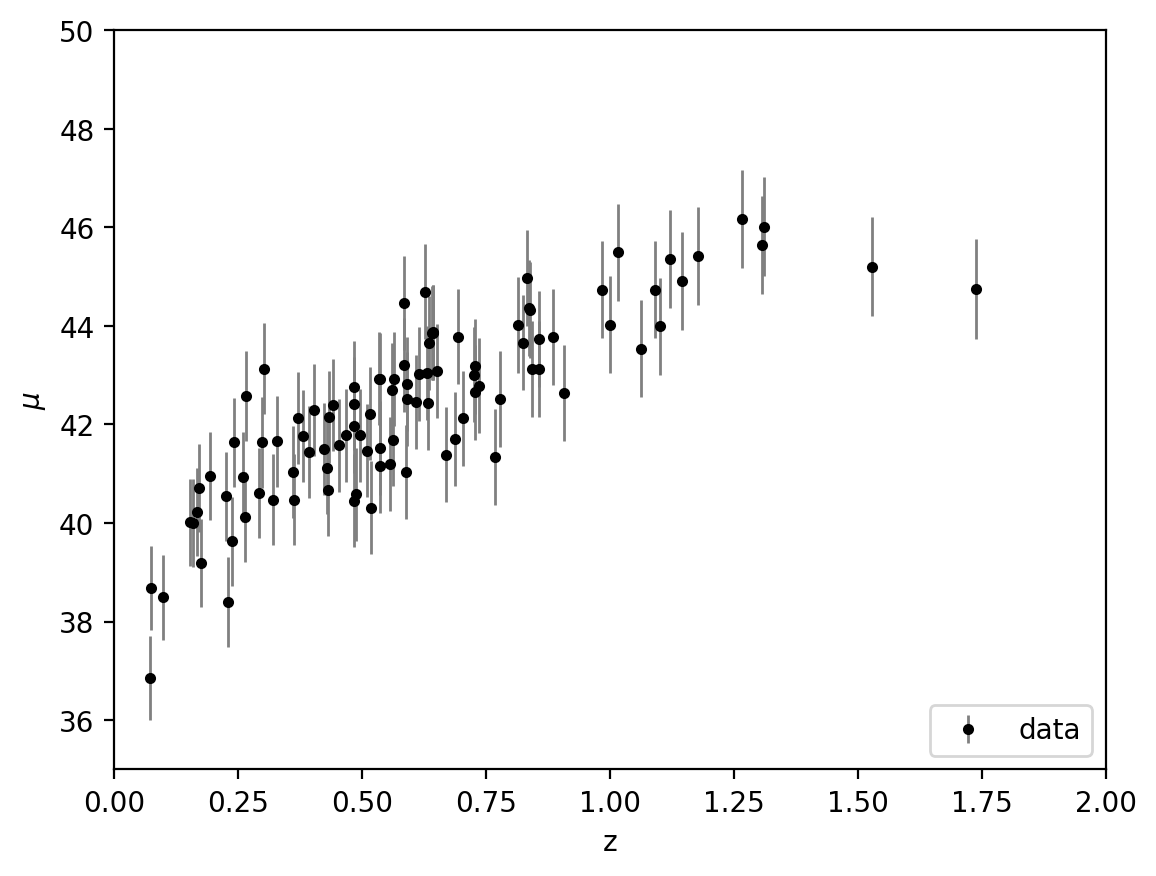

In [13]:
from astroML.datasets import generate_mu_z
from astropy.cosmology import LambdaCDM
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_13196\1981167200.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


(35.0, 50.0)

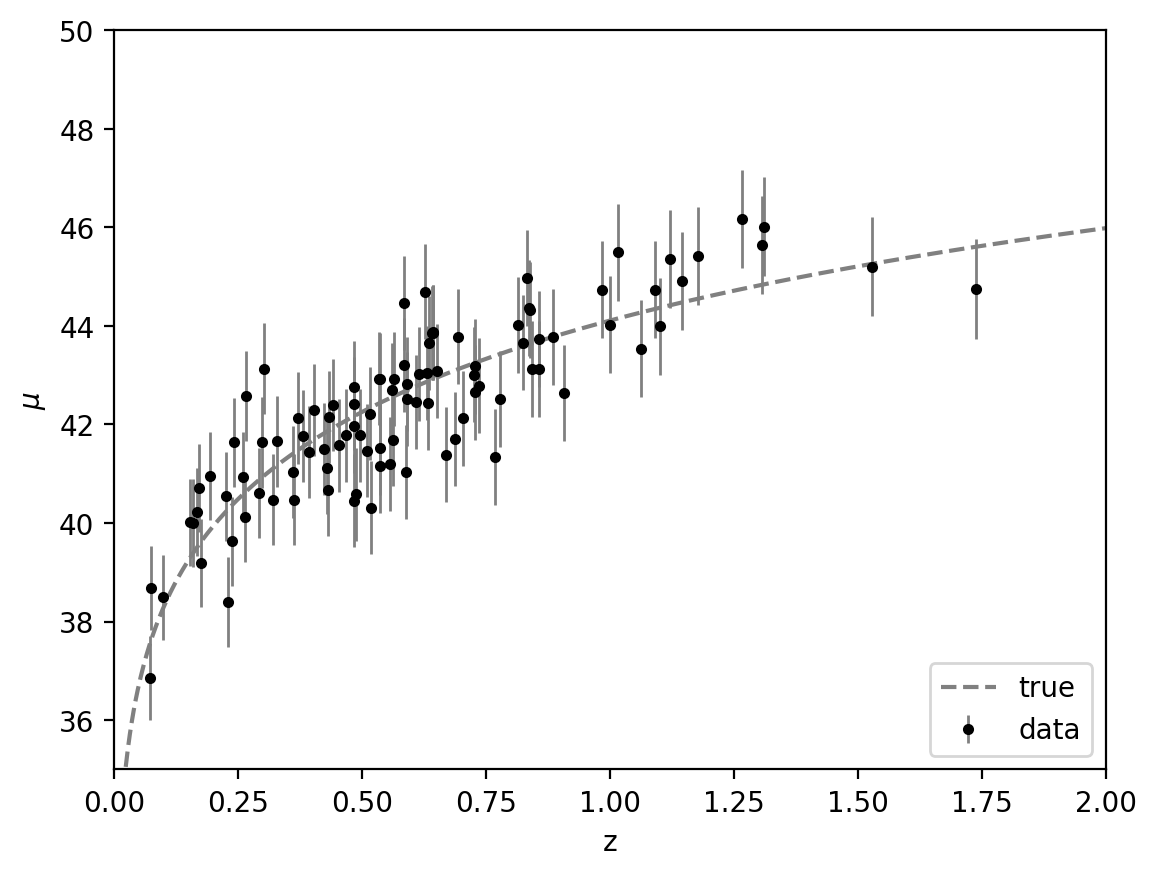

In [14]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
X_new = np.linspace(0,2,1000)
mu_true = cosmo.distmod(X_new)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(X_new, mu_true, '--', c='gray',label='true')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla

z_train, z_cv, mu_dmu_train, mu_dmu_cv = train_test_split(z_sample, np.array([mu_sample,dmu]).T, test_size=0.3, random_state=42)

mu_train, dmu_train = mu_dmu_train.T
mu_cv, dmu_cv = mu_dmu_cv.T

# GPR

Let's estimate the parameters of our kernel

First we can estimate the length scale of the RBF kernel by plotting the cross validation error

C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\Dynamic

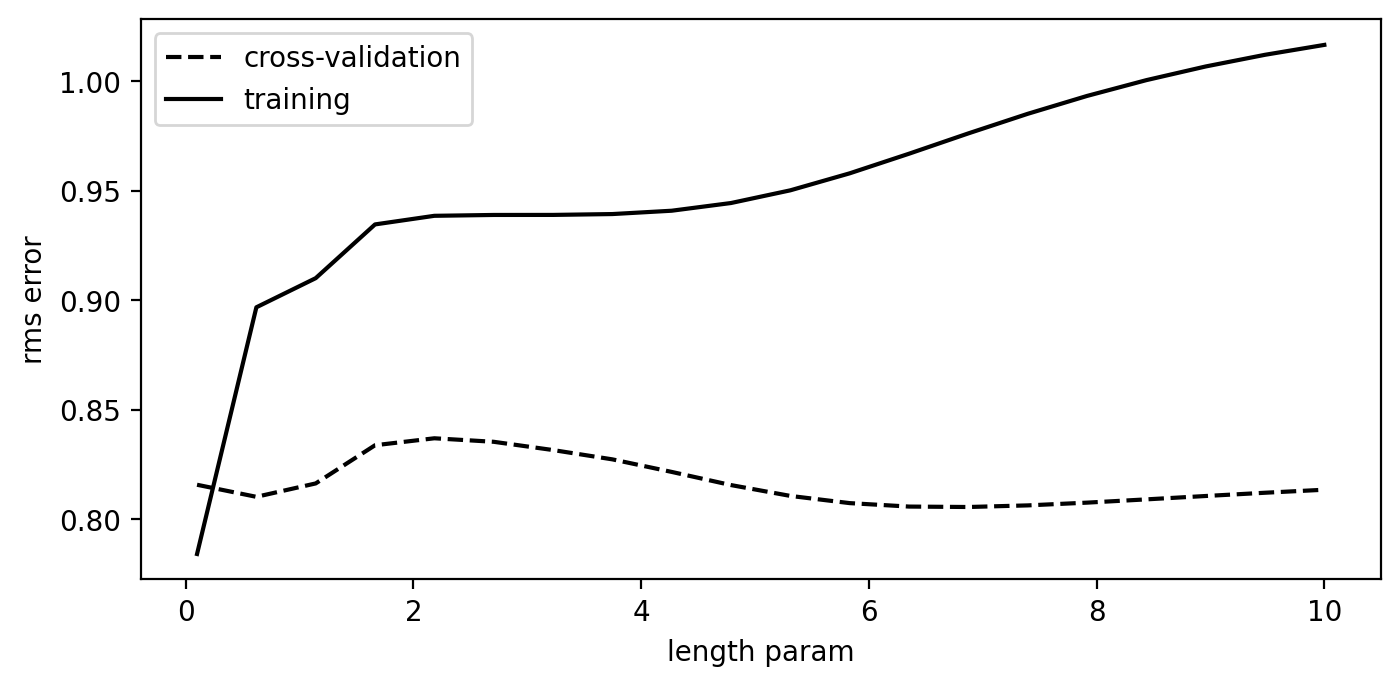

6.873684210526316

In [42]:
length = np.linspace(0.1, 10, 20)

training_err = np.zeros(length.shape)
crossval_err = np.zeros(length.shape)

fig = plt.figure(figsize=(8, 8))
for i, l in enumerate(length):


    kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(l, 'fixed')
    gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=dmu_train ** 2, 
                               random_state=42)
    
    gpr.fit(z_train.reshape(-1,1),  mu_train)

    y_train = gpr.predict(z_train.reshape(-1,1))
    y_cv = gpr.predict(z_cv.reshape(-1,1))
    
    training_err[i] = np.sqrt(np.sum((mu_train - y_train) ** 2)  / len(mu_train))
    crossval_err[i] = np.sqrt(np.sum((mu_cv - y_cv) ** 2) / len(mu_cv))

ax = fig.add_subplot(211)
ax.plot(length, crossval_err, '--k', label='cross-validation')
ax.plot(length, training_err, '-k', label='training')

ax.set_xlabel('length param')
ax.set_ylabel('rms error')
ax.legend(loc=2)

plt.show()

best_l = length[np.argmin(crossval_err)]
best_l

Since the kernel has two hyperparameters, we can estimate the best of both using a k-folding cross validation:

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

length = np.linspace(0.1, 10, 100)
const = np.linspace(1,10,100)
K=5
kernel = []
for c in const:
    for l in length:
        kernel.append(kernels.ConstantKernel(c, 'fixed') * kernels.RBF(l, 'fixed'))
#kernel = [kernels.ConstantKernel(c, (1e-3, 1e3)) * kernels.RBF(l, 'fixed') for c, l in zip(const, length)]

grid = GridSearchCV(GaussianProcessRegressor(), {'kernel': kernel}, scoring = 'neg_root_mean_squared_error', cv= K) # Try each degree with K-folds
grid.fit(z_sample.reshape(-1,1),  y = mu_sample)
p_opt = grid.best_params_
print(p_opt)

{'kernel': 1.65**2 * RBF(length_scale=9.5)}


In [38]:
print(p_opt)

{'kernel': 1.65**2 * RBF(length_scale=9.5)}


Then let's fit the GPR on our dataset

In [39]:
x = np.linspace(0,2,100)

kernel = 1.65**2 * kernels.RBF(9.5)
gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=dmu**2, 
                               random_state=0)
gpr.fit(z_sample.reshape(-1,1), mu_sample)
f, f_err = gpr.predict(x.reshape(-1,1), 
                         return_std=True)

# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gpr.kernel_.theta)

best-fit theta = [6.8473999  1.36058331]


Let's plot the resulting fit with the 1-$\sigma$ and 2-$\sigma$ contours:

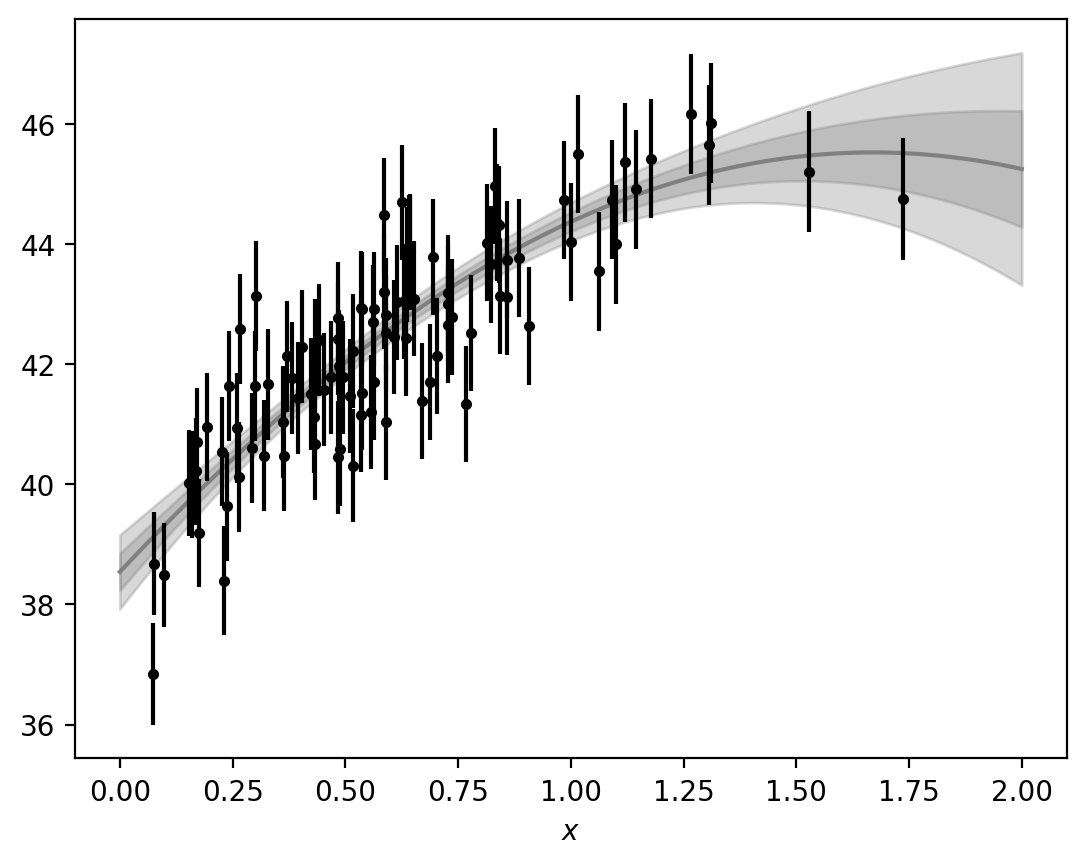

In [40]:
plt.plot(x, f, '-', color='gray')
plt.fill_between(x, f - 2 * f_err, f + 2 * f_err, 
                color='gray', alpha=0.3)

plt.fill_between(x, f - f_err, f + f_err, 
                color='gray', alpha=0.3)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms=6)

plt.xlabel('$x$')

plt.show()

# Parametric fit

First of all, I use curve_fit to find the best estimate for the parameters of my theorical model.

In [10]:
def th_model(z, H_0, O_m):
    cosmo_model = LambdaCDM(H0=H_0, Om0=O_m, Ode0=1-O_m)
    return cosmo_model.distmod(z).value

popt, pcov = curve_fit(th_model, z_sample, mu_sample, sigma = dmu, p0 = [cosmo.H(0).value, 0.27])
print('H0: ', popt[0])
print("Omega_m: ", popt[1])
print('Covariance:\n', pcov)

H0:  68.52120265079324
Omega_m:  0.3448320230369979
Covariance:
 [[55.89197883 -1.95107264]
 [-1.95107264  0.0802069 ]]


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_13196\2391285250.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")
C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\astropy\cosmology\flrw\base.py:1352: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Real parameters:      H_0 = 71.000, Omega_m = 0.270
Fit parameters: H_0 = 68.521, Omega_m = 0.345


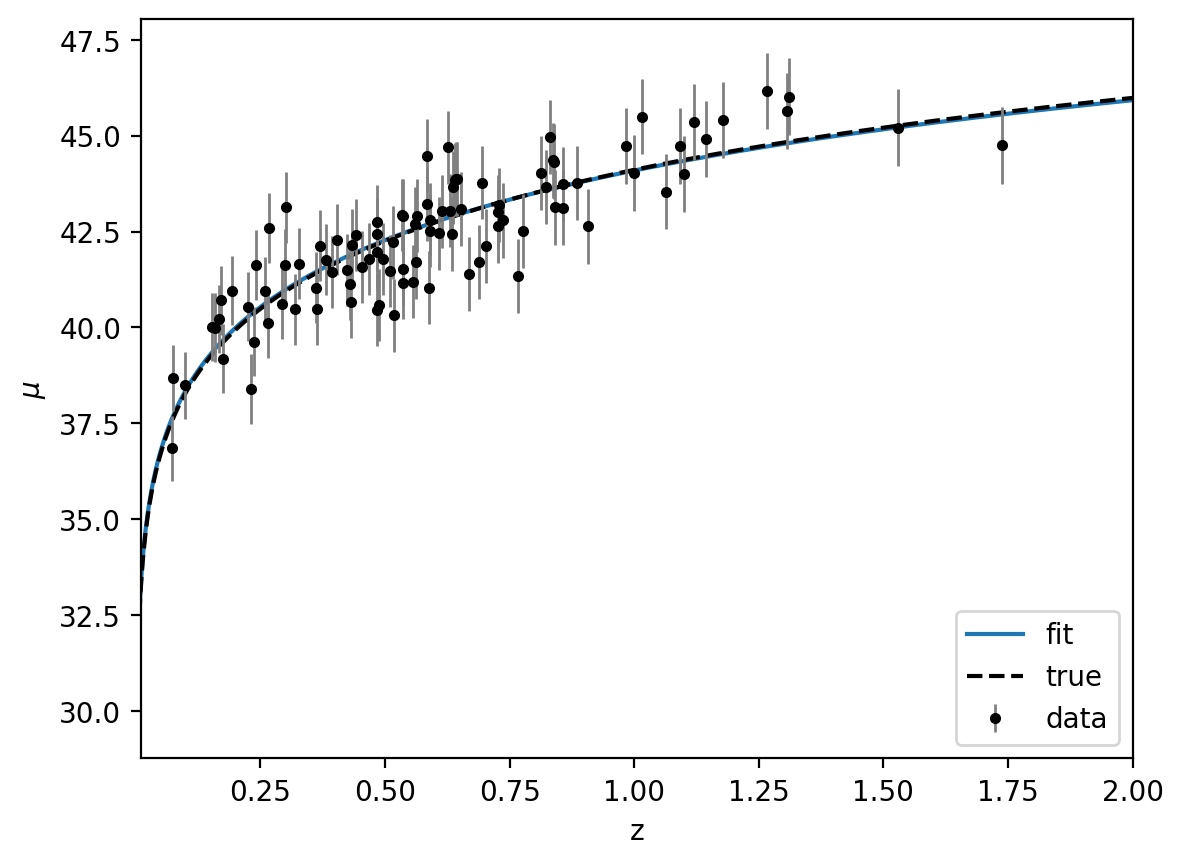

In [11]:
plt.plot(X_new, th_model(X_new,  popt[0], popt[1]), label = 'fit')
plt.plot(X_new, mu_true, '--', c='k',label='true')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0.01,2)

print('Real parameters:      H_0 = %.3f, Omega_m = %.3f' %(cosmo.H(0).value, 0.27))
print('Fit parameters: H_0 = %.3f, Omega_m = %.3f' %(popt[0], popt[1]))

# MCMC

We can estimate the parameter distribution using MCMC

In [12]:
def log_likelihood(theta, z, mu, dmu, model):
    H_0, Omega_m = theta
    return -0.5 * np.sum((mu - model(z, H_0, Omega_m)) ** 2 / dmu + np.log(dmu))

def log_prior(theta):
    H_0, Omega_m = theta
    if 40.0 < H_0 < 100.0 and 0.1 < Omega_m < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, z, mu, dmu, model):
    H_0, Omega_m = theta
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mu, dmu, model)

In [13]:
start_pos = popt + 1e-4 * np.random.randn(32, 2) #starting guesses from the curve_fit values with 32 walkers and 4 dimensions 
nwalkers, ndim = start_pos.shape
nsteps = 10000

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args = (z_sample, mu_sample, dmu, th_model)
)
sampler.run_mcmc(start_pos, nsteps, progress=True);

100%|██████████| 10000/10000 [05:30<00:00, 30.25it/s]


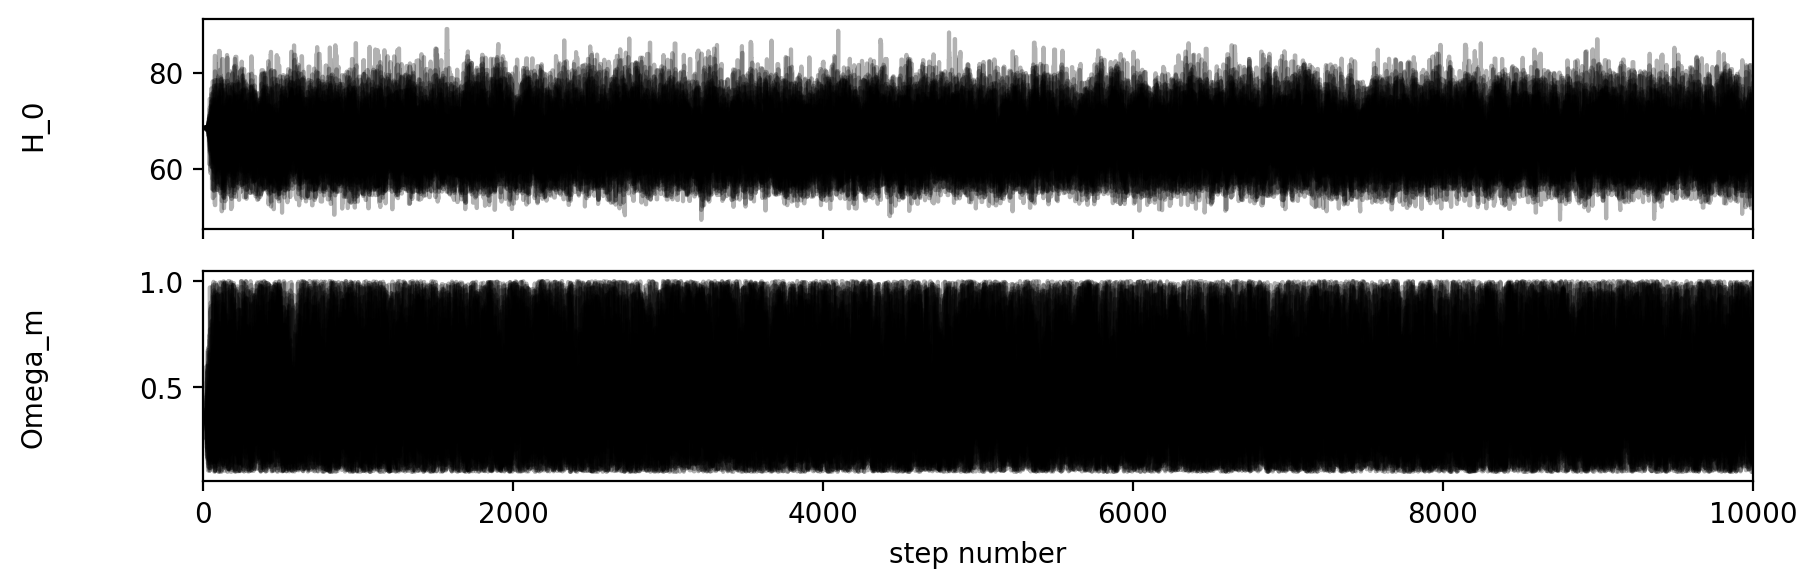

In [14]:
fig, axes = plt.subplots(2, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ["H_0", "Omega_m"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

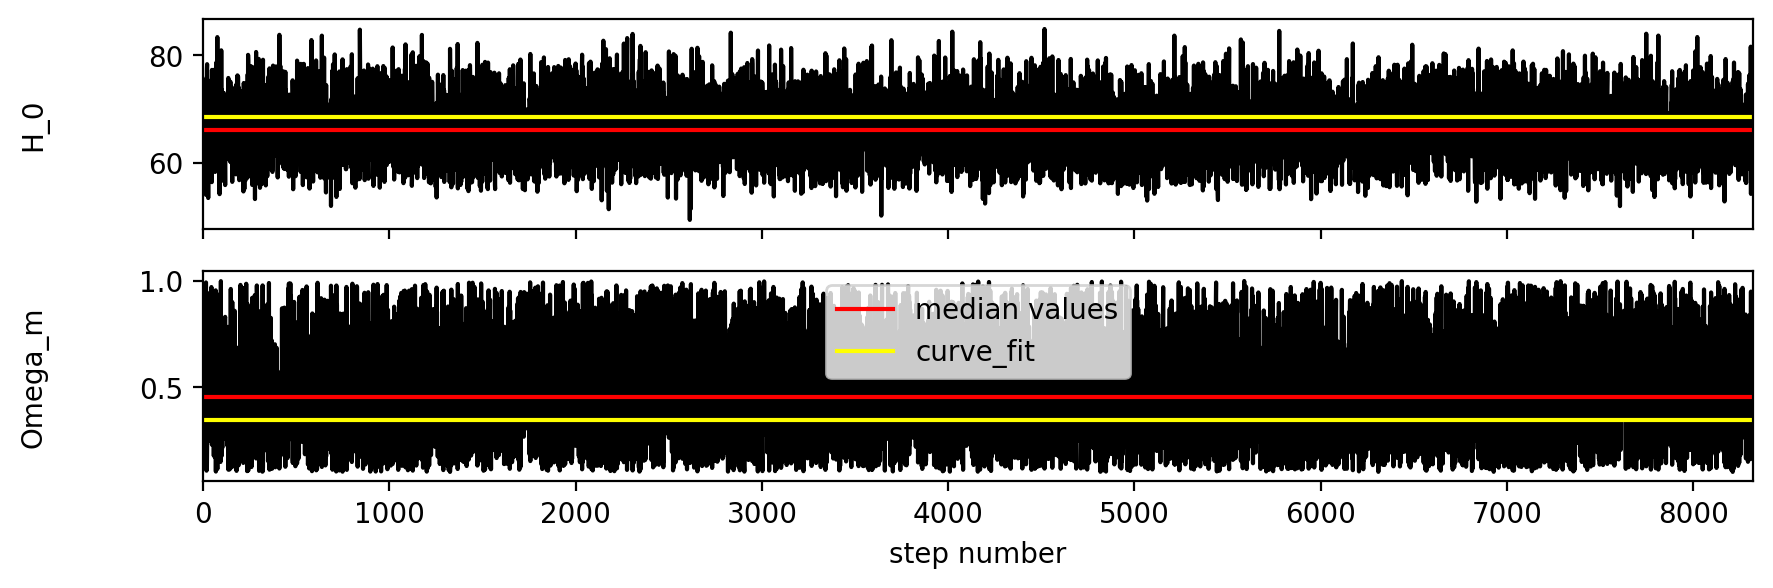

In [15]:
burn = 100
tau = sampler.get_autocorr_time()
flat_samples = sampler.get_chain(discard=burn, thin = int(np.mean(tau)), flat=True)

fig, axes = plt.subplots(2, figsize=(10, 3), sharex=True)
labels = ["H_0", "Omega_m"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], "k")
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(np.median(flat_samples[:, i]), color = 'red', label = 'median values')
    ax.axhline(popt[i], color = 'yellow', label = 'curve_fit')
axes[-1].set_xlabel("step number")
plt.legend();

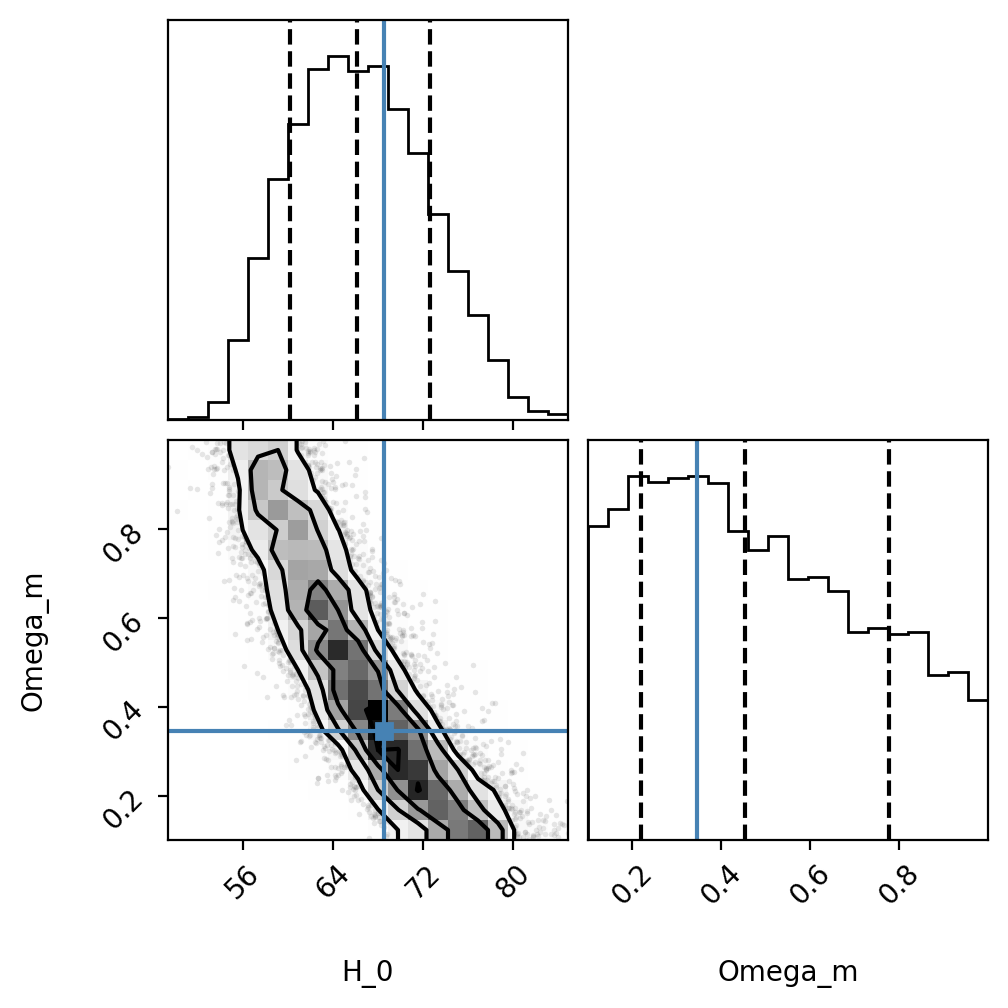

In [16]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[popt[0], popt[1]], quantiles = [0.16, 0.5, 0.84]
); # in blue there are the curve_fit best parameters, our initial guesse

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\1190710996.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$");
C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\astropy\cosmology\flrw\base.py:1352: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


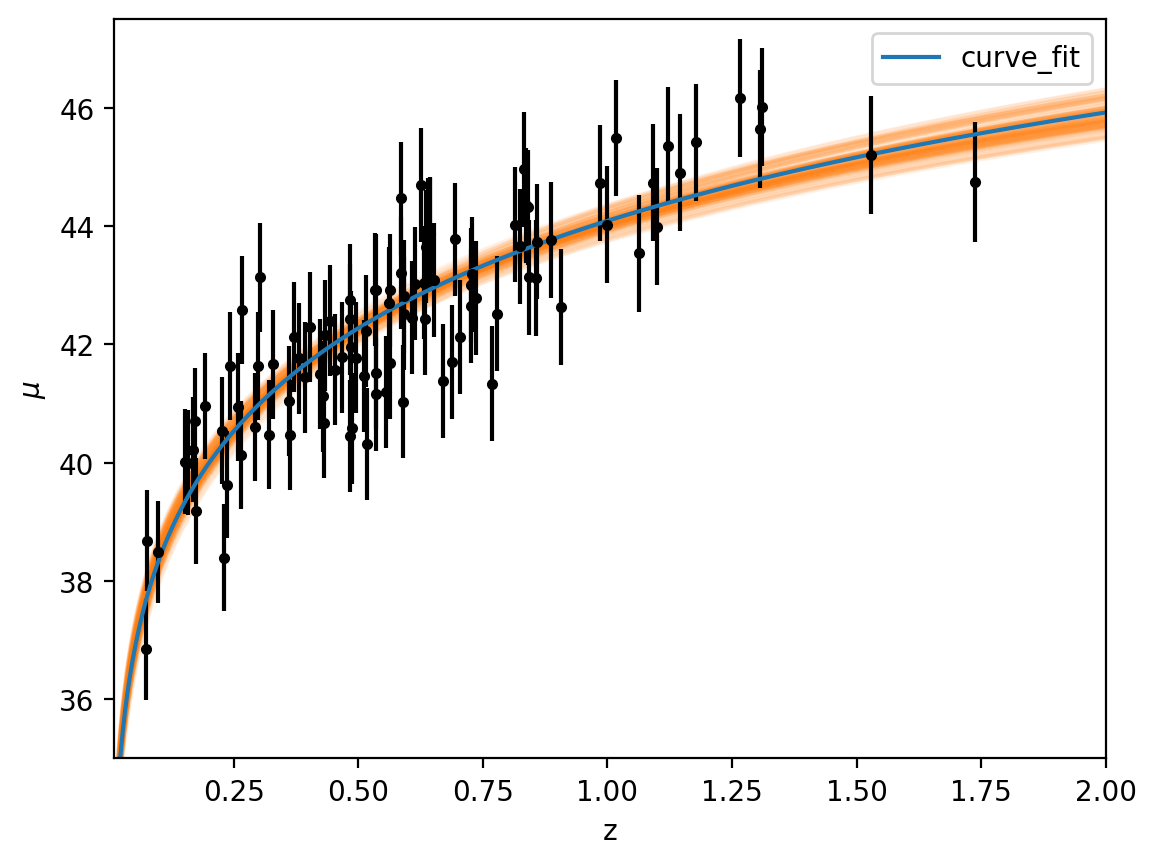

In [17]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(X_new, th_model(X_new, sample[0], sample[1]), "C1", alpha=0.1) #plotting some samples
    
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt=".k", ecolor='gray', lw=1, capsize=0)
plt.plot(X_new, th_model(X_new, popt[0], popt[1]), label="curve_fit")
plt.xlim(0.01,2)
plt.ylim(35, 47.5)
plt.legend()

plt.xlabel("z")
plt.ylabel("$\mu$");

In [18]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\3404182656.py:6: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
log_prob = sampler.get_log_prob(discard=burn, thin=int(np.mean(tau)), flat=True)
max_posterior = flat_samples[np.argmax(log_prob)]
print('Maxima a posteriori = ', max_posterior)

Maxima a posteriori =  [69.36977907  0.31386421]


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\545917449.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$");


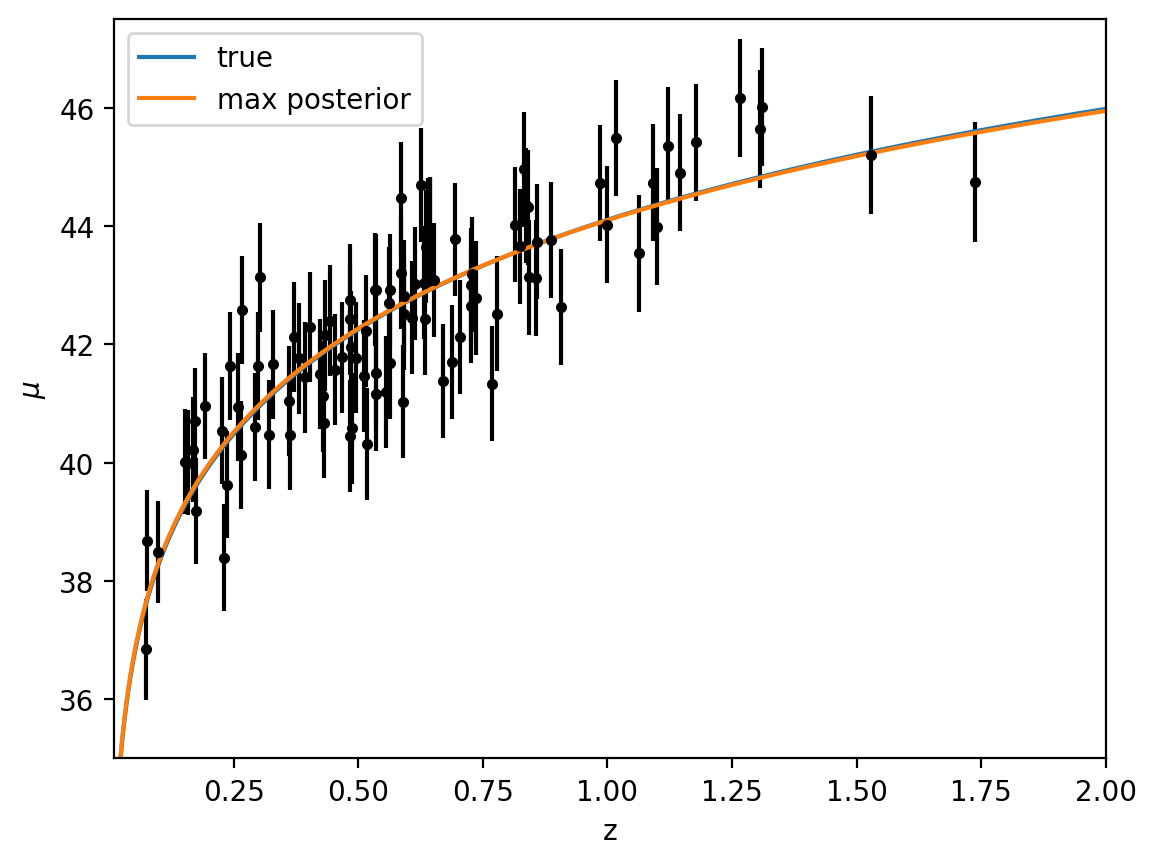

In [20]:
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt=".k", ecolor='gray', lw=1, capsize=0)
plt.plot(X_new, mu_true, label="true")
plt.plot(X_new, th_model(X_new, max_posterior[0], max_posterior[1]), label="max posterior")
plt.xlim(0.01,2)
plt.ylim(35, 47.5)
plt.legend()

plt.xlabel("z")
plt.ylabel("$\mu$");

# Nested sampling

In [21]:
ndim = 2

def ptform(u, model):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our prior for each variable."""
    
    H_0 = uniform.ppf(u[0], 40, 100) 
    Omega_m = uniform.ppf(u[1], 0.1, 1)
    
    return [H_0, Omega_m]

1242it [00:20, 59.50it/s, +300 | bound: 1 | nc: 1 | ncall: 11343 | eff(%): 13.964 | loglstar:   -inf < -41.076 <    inf | logz: -43.915 +/-  0.077 | dlogz:  0.001 >  0.309]


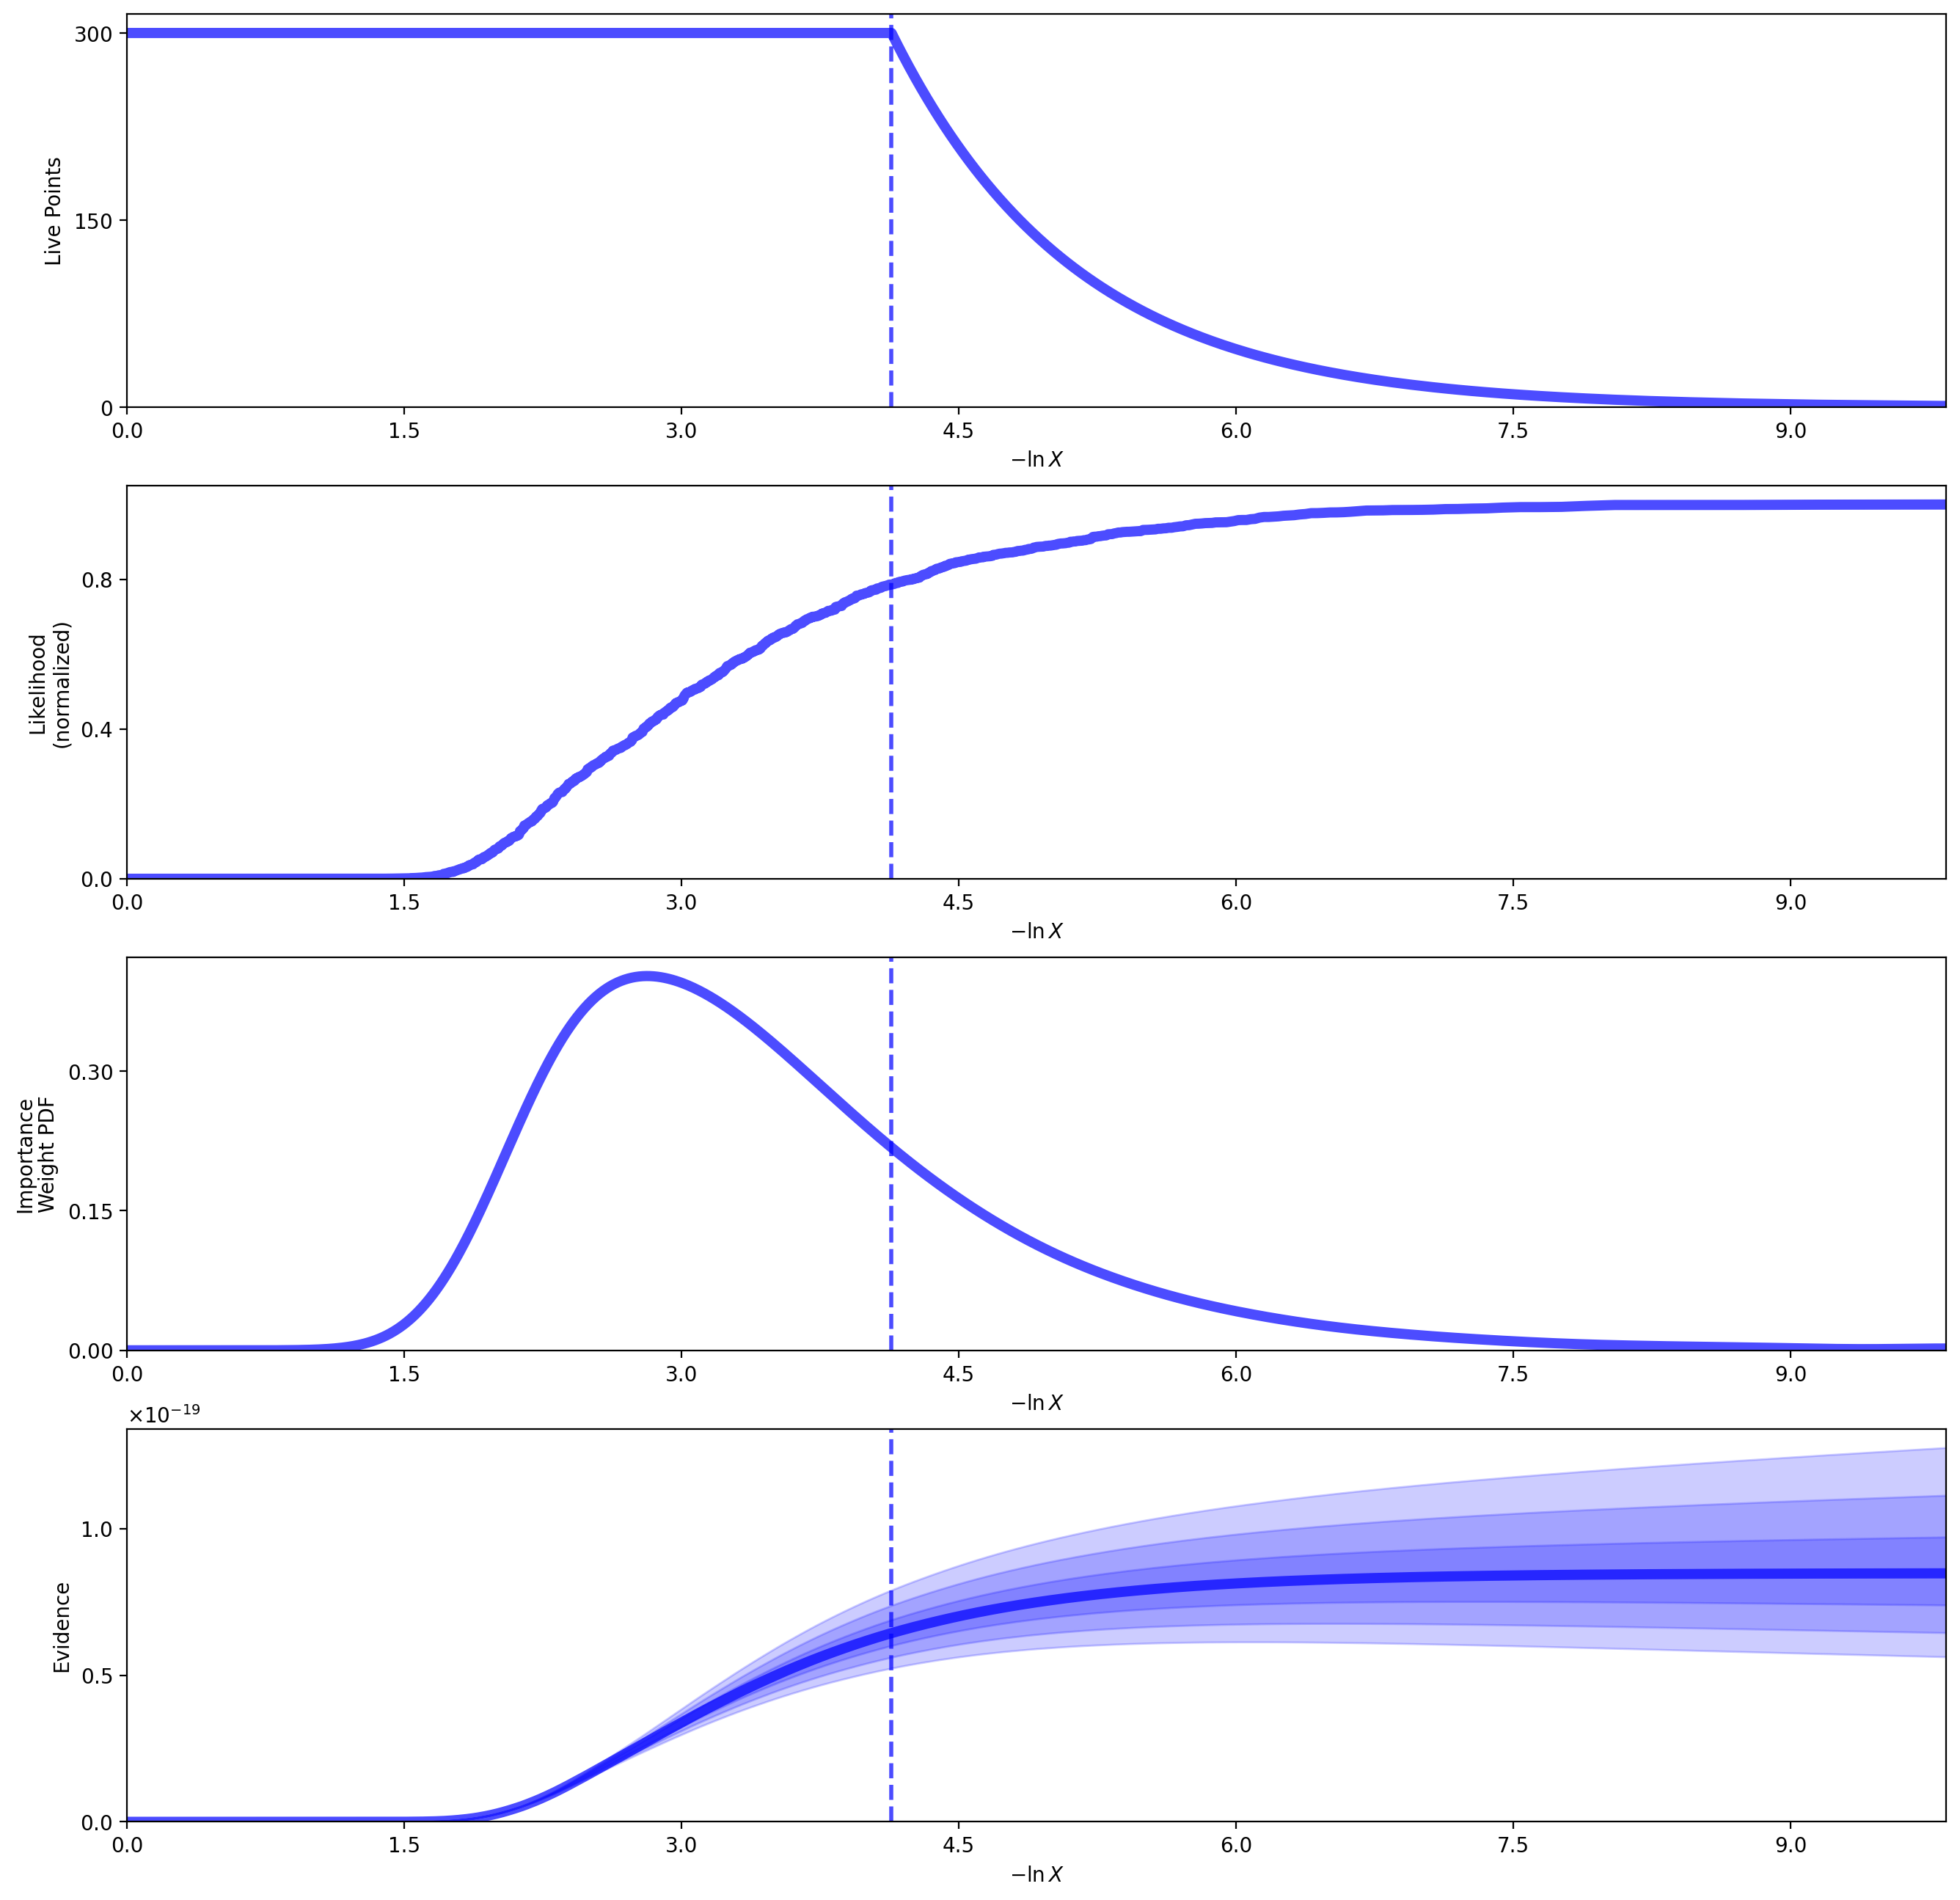

In [22]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[z_sample, mu_sample, dmu, th_model], ptform_args=[th_model], nlive=300)
sampler.run_nested()
sresults = sampler.results

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

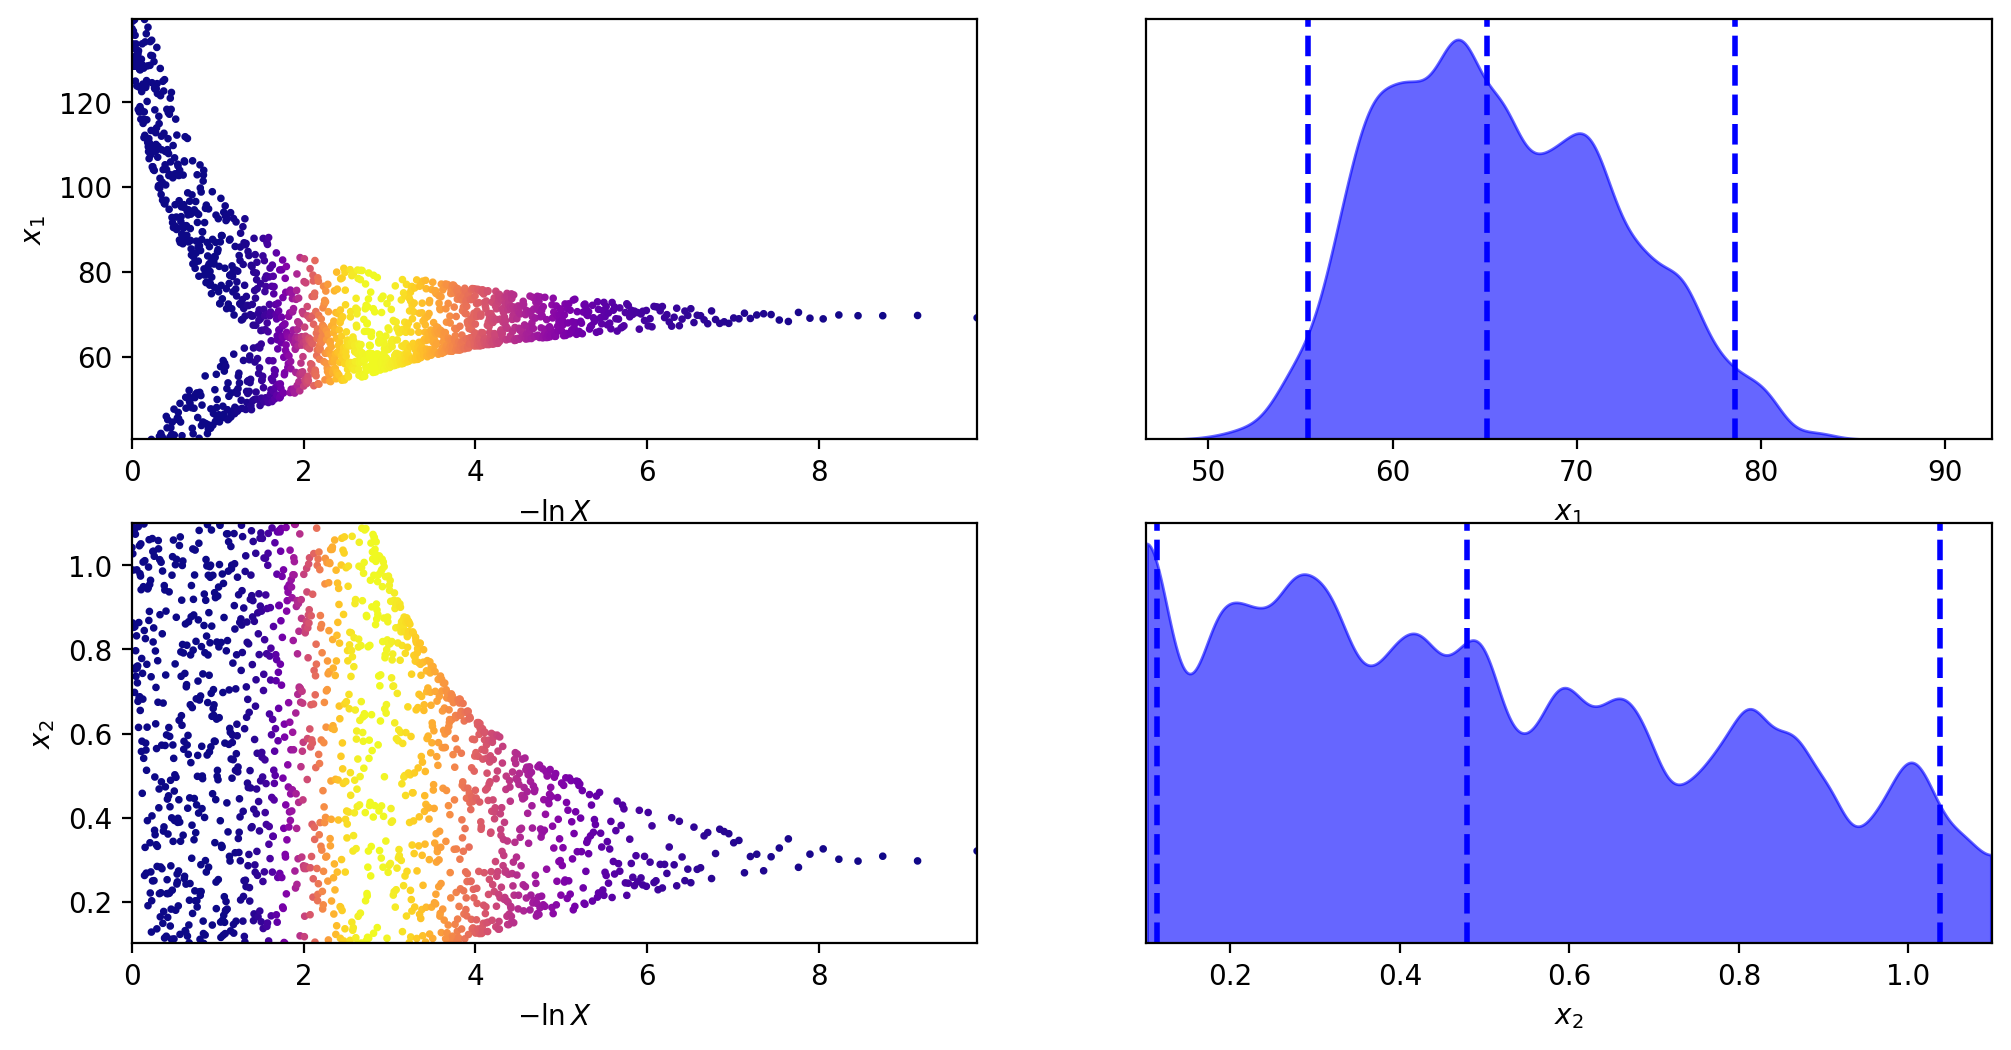

In [23]:
tfig, taxes = dyplot.traceplot(sresults)

In [24]:
# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 8.472576366392521e-20
90% parameter credible regions are:
 [[58.06016961703904, 74.69465203651602], [0.18045812795395333, 0.9155958392571776]]

Mean and covariance of parameters are: [65.78105804  0.51569144]
[[39.61020096 -1.47221112]
 [-1.47221112  0.07452016]]


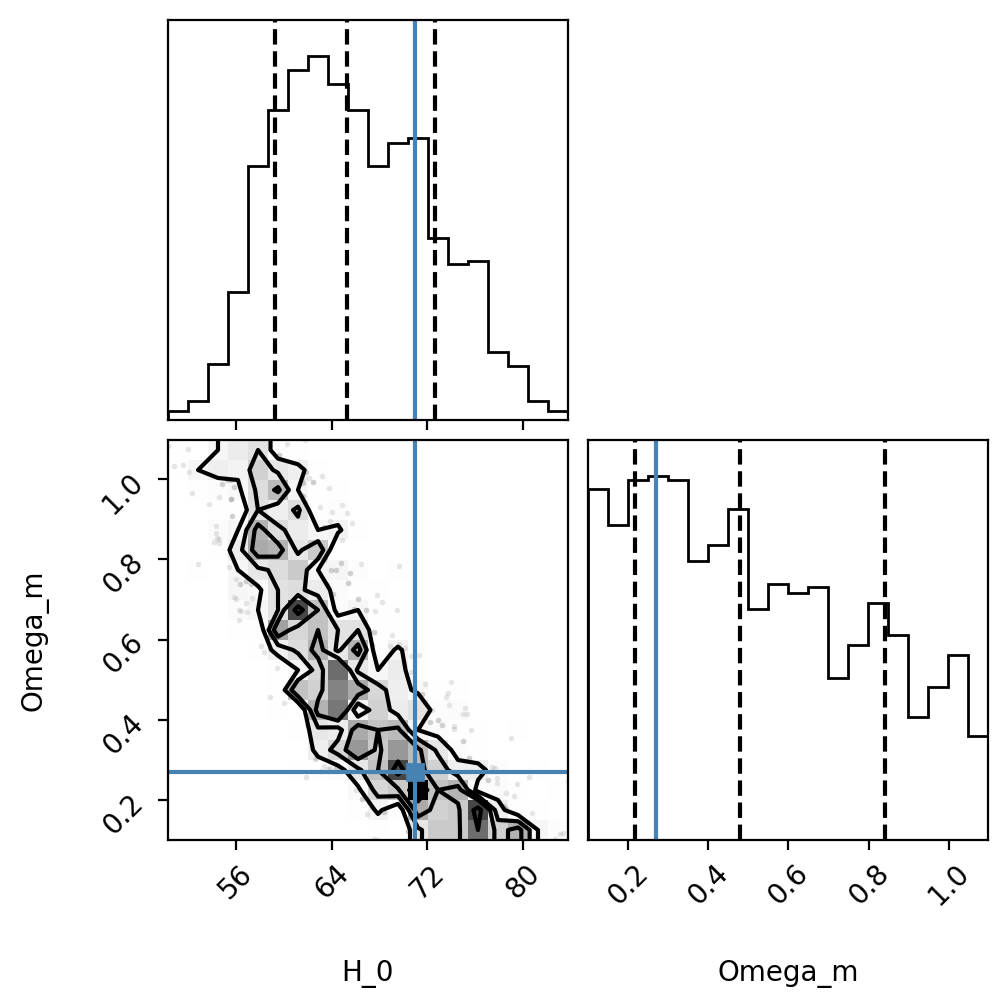

In [25]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)
labels = ["H_0", "Omega_m"]
corner.corner(samples_equal, labels=labels, truths=[cosmo.H(0).value, 0.27], quantiles = [0.16, 0.5, 0.84]); #in blue the true parameters

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\2891202706.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$");
C:\Users\Admin\anaconda3\envs\Dynamics\Lib\site-packages\astropy\cosmology\flrw\base.py:1352: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


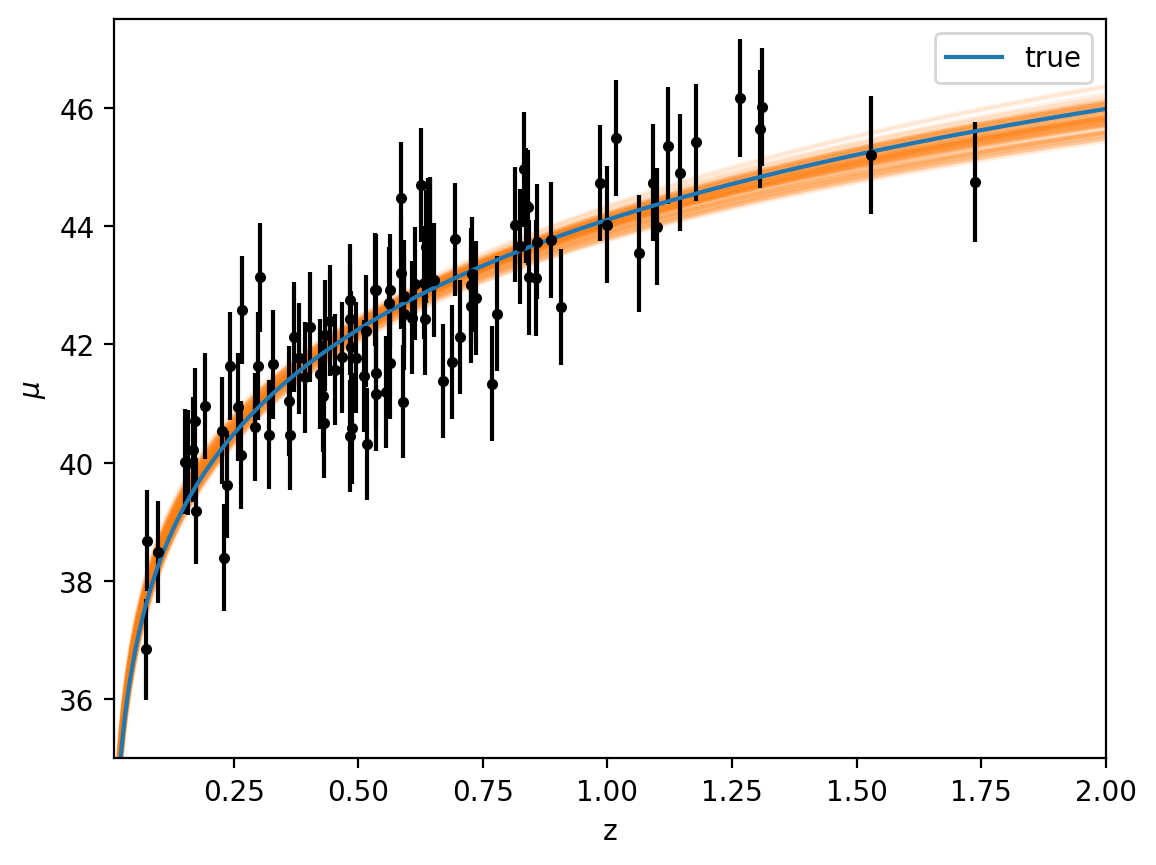

In [26]:
inds = np.random.randint(len(samples_equal), size=100)
for ind in inds:
    sample = samples_equal[ind]
    plt.plot(X_new, th_model(X_new, sample[0], sample[1]), "C1", alpha=0.1)
    
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt=".k", ecolor='gray', lw=1, capsize=0)
plt.plot(X_new, mu_true, label="true")
plt.xlim(0.01,2)
plt.ylim(35, 47.5)
plt.legend()

plt.xlabel("z")
plt.ylabel("$\mu$");

In [27]:
for i in range(ndim):
    mcmc = np.percentile(samples_equal[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\1534531505.py:4: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
sresults.summary()

Summary
nlive: 300
niter: 1242
ncall: 11043
eff(%): 13.964
logz: -43.915 +/-  0.136


# No dark energy assumption

In [29]:
ndim = 1

def log_likelihood(theta, z, mu, dmu, model):
    H_0 = float(theta)
    Omega_m = 1
    return -0.5 * np.sum((mu - model(z, H_0, Omega_m)) ** 2 / dmu + np.log(dmu))

def ptform(u, model):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our prior for each variable."""
    
    H_0 = uniform.ppf(u[0], 40, 100)
    
    return [H_0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_680\3887445070.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H_0 = float(theta)
1098it [00:16, 19.34it/s, bound: 0 | nc: 103 | ncall: 10931 | eff(%): 10.045 | loglstar:   -inf < -42.000 <    inf | logz: -45.181 +/-  0.091 | dlogz:  0.543 >  0.309]C:\Users\Admin\AppData\Local\Temp\ipykernel_680\3887445070.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H_0 = float(theta)
1239it [00:17, 69.77it/s, +300 | bound: 1 | nc: 1 | ncall: 11486 | eff(%): 13.758 | loglstar:   -inf < -41.859 <    inf | logz: -44.660 +/-  0.075 | dlogz:  0.001 >  0.309]


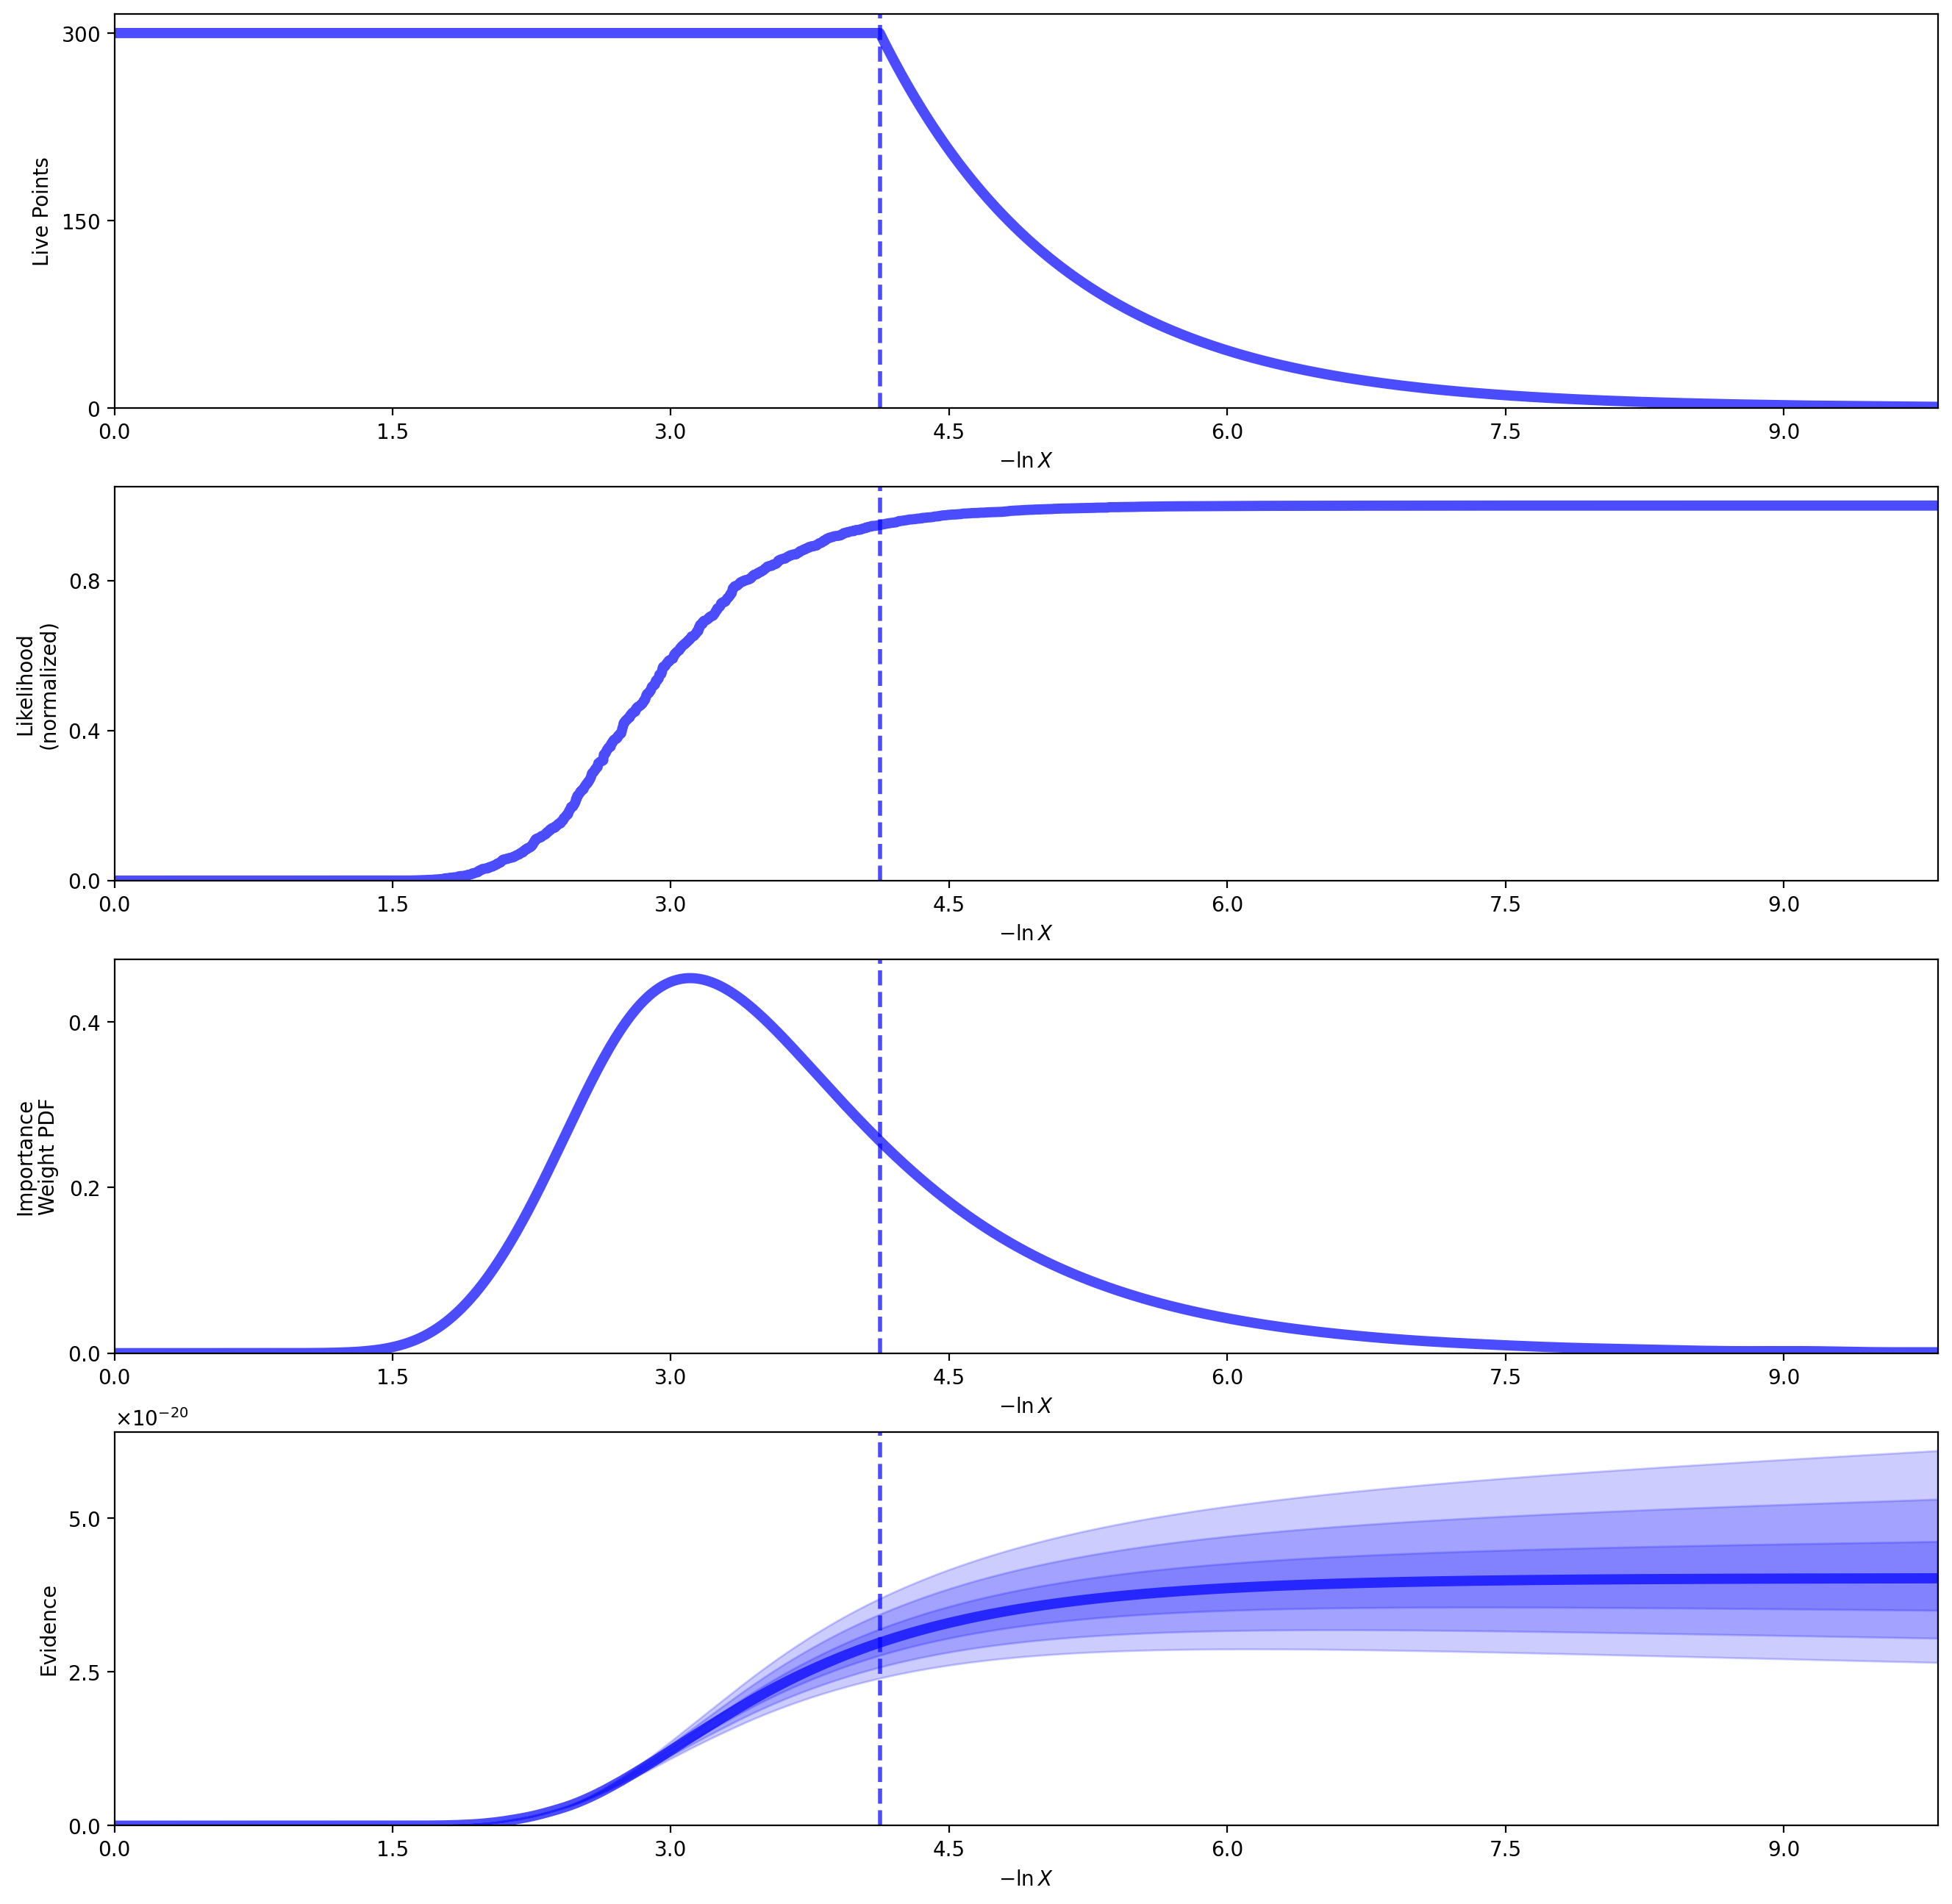

In [30]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim, logl_args=[z_sample, mu_sample, dmu, th_model], ptform_args=[th_model], nlive=300)
sampler.run_nested()
sresults_nde = sampler.results

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_nde)

In [32]:
# Extract sampling results.
samples = sresults_nde.samples  # samples
weights = np.exp(sresults_nde.logwt - sresults_nde.logz[-1])  # normalized weights


evidence = sresults_nde.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.10, 0.90], weights=weights)
             for samps in samples.T]
print('90% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Bayesian evidence 4.022434478361305e-20
90% parameter credible regions are:
 [[54.51690373936756, 61.12912653828636]]

Mean and covariance of parameters are: [57.71905637]
[[6.92848749]]


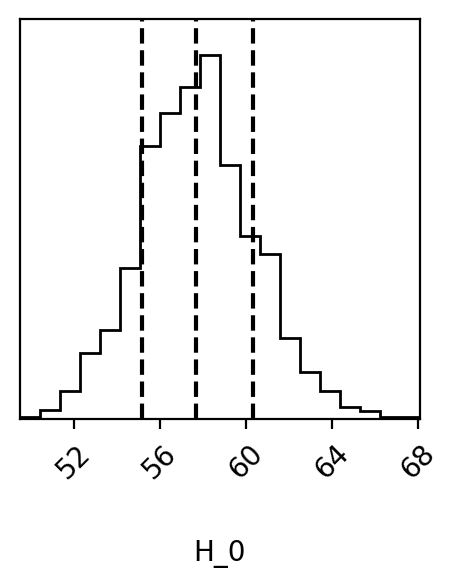

In [33]:
# Resample weighted samples.
samples_equal_nde = dyfunc.resample_equal(samples, weights)
labels = ["H_0"]
corner.corner(samples_equal_nde, labels=labels, truths=[cosmo.H(0).value], quantiles = [0.16, 0.5, 0.84]);

In [34]:
for i in range(ndim):
    mcmc = np.percentile(samples_equal_nde[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\631082642.py:4: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

In [35]:
sresults_nde.summary()

Summary
nlive: 300
niter: 1239
ncall: 11186
eff(%): 13.758
logz: -44.660 +/-  0.139


# Let's compare the two models

In [36]:
np.exp(sresults.logz[-1])/np.exp(sresults_nde.logz[-1]) 

2.106330485175275

The Bayes factor is inconclusive. This means that our data are not enough to decise what model is the best. 

# Cloning data

First of all, I sample the distribution of redshifts using the given data.

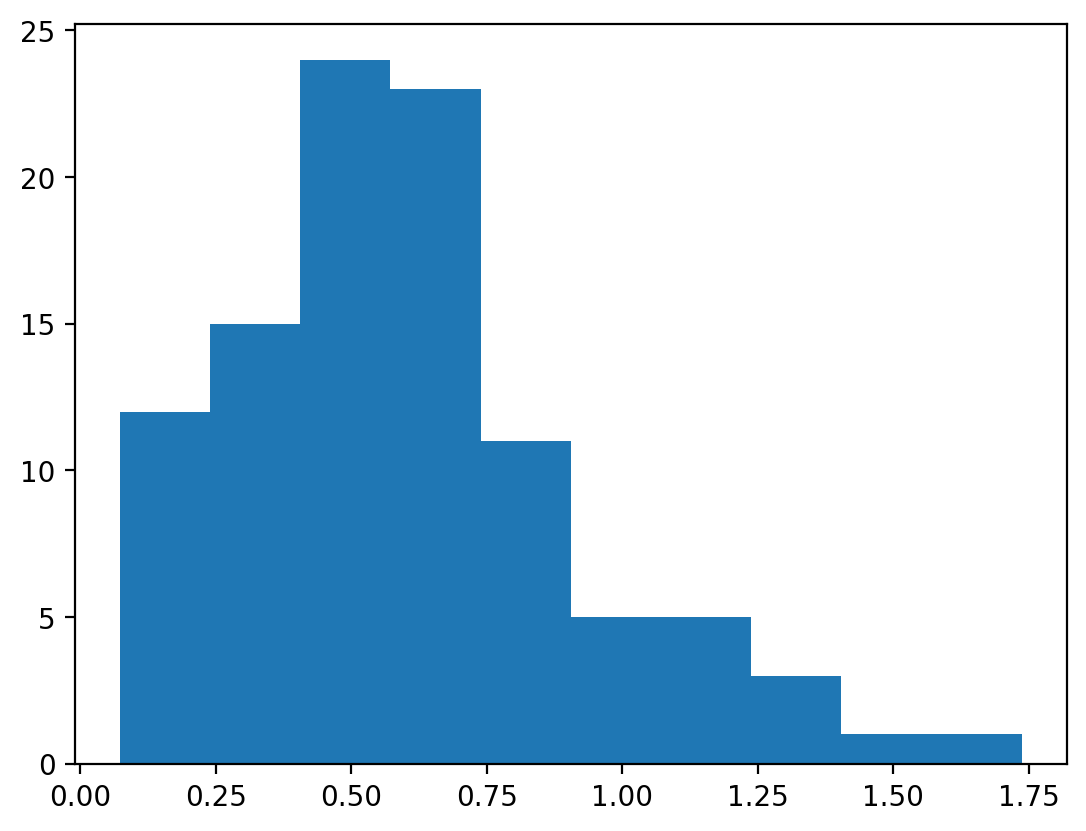

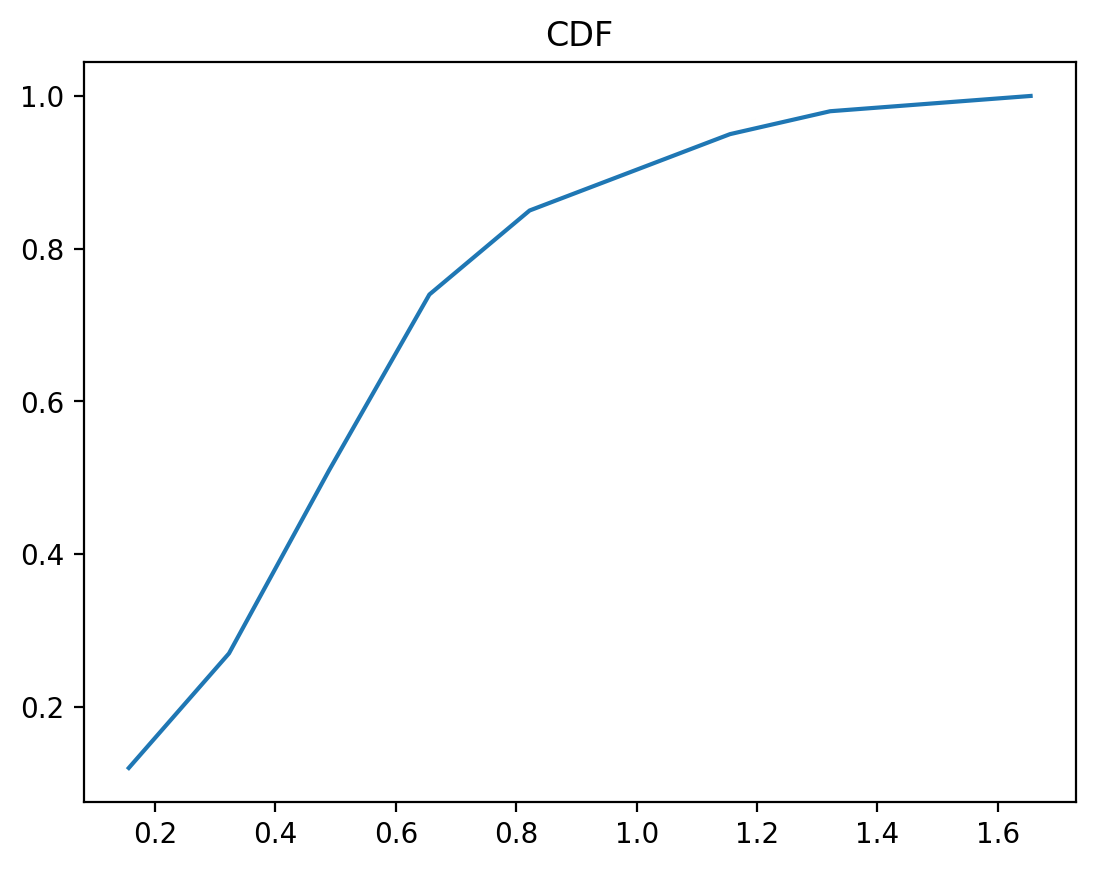

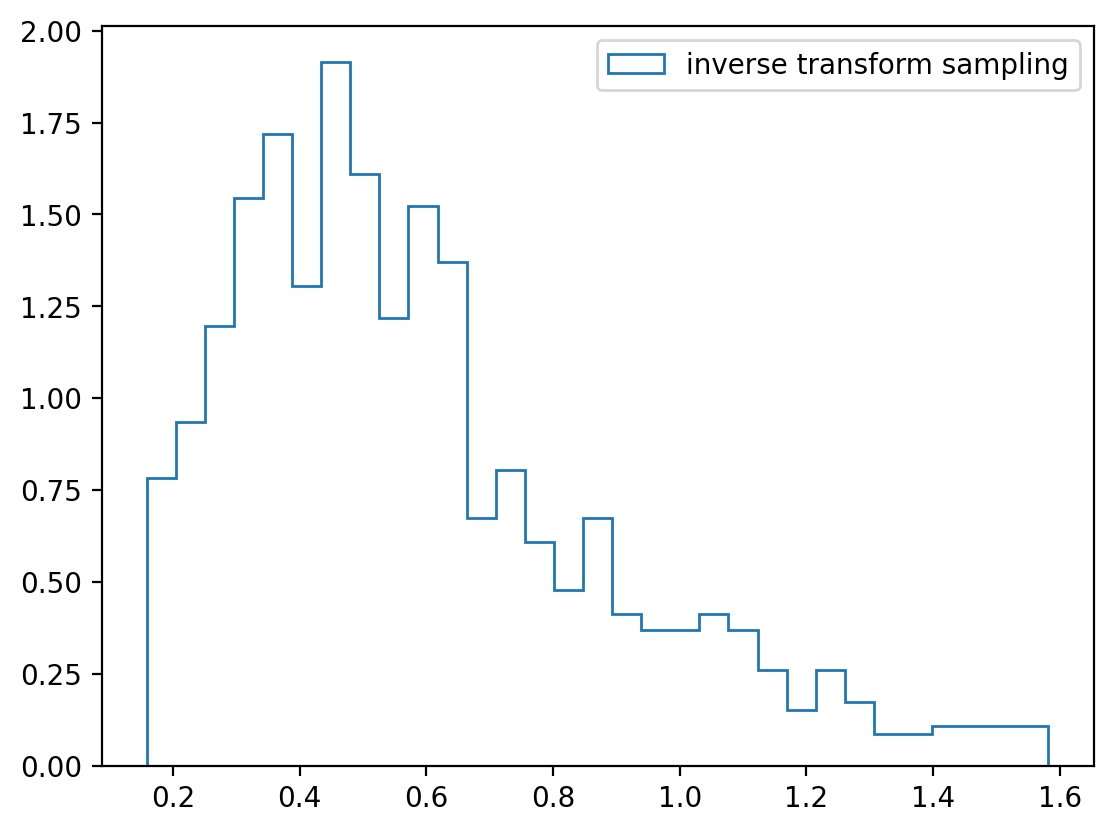

In [40]:
counts, bins, bars = plt.hist(z_sample, bins = int(np.sqrt(len(z_sample))), label = 'redshift distribution')
N = 1000

x_data = (bins[1:] + bins[:-1]) / 2

cdf_norm = np.cumsum(counts) / np.sum(counts) #comulative density function

plt.show()
plt.plot(x_data, cdf_norm)
plt.title('CDF')
plt.show()

fit = scipy.interpolate.interp1d(cdf_norm, x_data)

z_resampled = fit(np.random.uniform(min(cdf_norm),max(cdf_norm), N)) #sampling along the cdf

plt.hist(z_resampled, bins = int(np.sqrt(len(z_resampled))), density=True, histtype='step', label = 'inverse transform sampling')

plt.legend()
plt.show()

In [43]:
mu_nested=[]
mu_gpr=[]
for z in z_resampled:
    H_0, Omega_m = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_nested.append(th_model(z, H_0, Omega_m))
    
    
    mu_fit, sigma = gpr.predict([[z]], 
                           return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Admin\AppData\Local\Temp\ipykernel_680\768299444.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


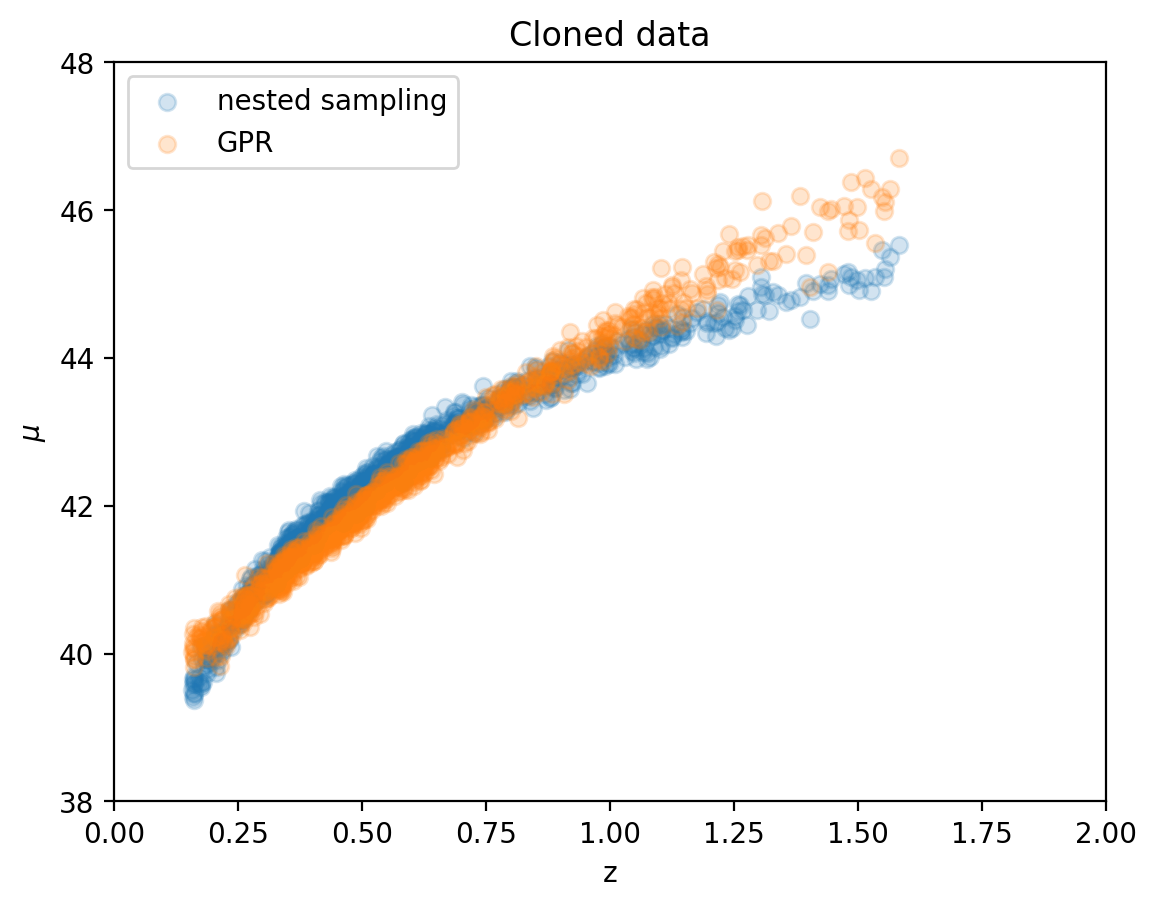

In [45]:
plt.scatter(z_resampled,mu_nested,alpha=0.2,label="nested sampling")
plt.scatter(z_resampled,mu_gpr,alpha=0.2,label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(38,48)
plt.title("Cloned data")
plt.legend()